In [40]:
import pandas as pd
import numpy as np
import pickle

In [48]:
input_path = 'H:\RediMinds\VCQI'
train = pd.read_csv(input_path+"\VCQI_clean_train.csv")
test = pd.read_csv(input_path+"\VCQI_clean_test.csv")

In [49]:
x_train = train.drop(labels='INTRA_OP_COMPLICATIONS', axis = 'columns').copy()
y_train = train['INTRA_OP_COMPLICATIONS'].copy()
x_test = test.drop(labels='INTRA_OP_COMPLICATIONS', axis = 'columns').copy()
y_test = test['INTRA_OP_COMPLICATIONS'].copy() 

# Decision Tree Classifier

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
DTC = DecisionTreeClassifier()
parameter_dist = { 'max_features':['sqrt','log2',None],
                  'min_samples_leaf': [1,5,10,15,20,25,30,35,40,45,50], 
                  'class_weight' :[None,'balanced'], 
                  'random_state': [1234]}  
classifier_DTC = GridSearchCV(DTC, parameter_dist, n_jobs = -1, scoring = 'roc_auc', cv = 5 )
results_classifier_DTC = classifier_DTC.fit(x_train, y_train)
y_DTC = results_classifier_DTC.predict(x_test)


In [53]:
classifier = results_classifier_DTC
results_DTC = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_DTC['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_DTC['true_label'] = np.array(y_test)

In [58]:
# Decison Tree Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_DTC)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_DTC)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_DTC)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_DTC['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_DTC)))

{'class_weight': 'balanced', 'max_features': None, 'min_samples_leaf': 50, 'random_state': 1234}

 Model Best CV score: 
0.7574934173629437

 Model Balanced Accuracy: 
0.7042161016949153

 Confusion Matrix : 
[[631 313]
 [ 13  37]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       944
           1       0.11      0.74      0.18        50

    accuracy                           0.67       994
   macro avg       0.54      0.70      0.49       994
weighted avg       0.94      0.67      0.76       994


 AUC-ROC: 
0.7707733050847457

 PR-ROC: 
0.22222935536124605


In [55]:
def bootstrapped_AUC(result):
    from sklearn.utils import resample
    from tqdm import tqdm

    n_iter = 10000
    roc_auc = list()
    prc_auc = list()


    for i in range(n_iter):
        result_sample = resample(result, n_samples = len(result),random_state=i)
        
        #Calculating AUROC for each sample
        y_ACTUAL= result_sample['true_label']
        scores_prob = result_sample['pred_prob']
        fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
        roc_auc.append(metrics.auc(fpr, tpr))

        #calculate AUPRC for each sample
        y_ACTUAL = result_sample['true_label']
        scores_prob = result_sample['pred_prob']
        yhat = result_sample['pred_label']
        precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
        prc_auc.append(metrics.auc(recall,precision))
    
    return roc_auc, prc_auc

In [56]:
roc_auc_DTC, pr_auc_DTC = bootstrapped_AUC(results_DTC)

In [57]:
dict = {'roc_auc_DTC': roc_auc_DTC,
        'pr_auc_DTC': pr_auc_DTC,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_DTC,pr_auc_DTC
count,10000.000000,10000.000000
mean,0.770499,0.223725
std,0.033259,0.046795
min,0.648946,0.076965
2.5%,0.702743,0.135775
50%,0.771303,0.221833
97.5%,0.833378,0.319153
max,0.885914,0.429052


# Random Forest Classifier

In [139]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
RFC = RandomForestClassifier(random_state= 42)
parameter_dist = {'n_estimators': [100,200,300,500], 'max_features':['sqrt','log2',None],
  'min_samples_leaf': [5,10,20,25,30,35,40,45,50], 'class_weight' :[None,'balanced'] 
}  
classifier_RFR = GridSearchCV(RFC, parameter_dist, n_jobs = -1,cv=5, scoring = 'roc_auc', return_train_score=True)
results_classifier_RFR = classifier_RFR.fit(x_train, y_train)
y_RFR = results_classifier_RFR.predict(x_test)


In [140]:
classifier = results_classifier_RFR
results_RFR = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_RFR['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_RFR['true_label'] = np.array(y_test)

In [143]:
# Random Forest Classifier Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_RFR)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_RFR)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_RFR)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_RFR['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_RFR)))

{'class_weight': 'balanced', 'max_features': None, 'min_samples_leaf': 10, 'n_estimators': 100}

 Model Best CV score: 
0.708737429261521

 Model Balanced Accuracy: 
0.5073516949152542

 Confusion Matrix : 
[[939   5]
 [ 49   1]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       944
           1       0.17      0.02      0.04        50

    accuracy                           0.95       994
   macro avg       0.56      0.51      0.50       994
weighted avg       0.91      0.95      0.92       994


 AUC-ROC: 
0.7163347457627118

 PR-ROC: 
0.10979249189598664


In [144]:
roc_auc_RFR, pr_auc_RFR = bootstrapped_AUC(results_RFR)

In [145]:
dict = {'roc_auc_RFR': roc_auc_RFR,
        'pr_auc_RFR': pr_auc_RFR,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_RFR,pr_auc_RFR
count,10000.000000,10000.000000
mean,0.716439,0.115018
std,0.035284,0.026862
min,0.567969,0.037873
2.5%,0.645848,0.070125
50%,0.717415,0.112270
97.5%,0.784315,0.174091
max,0.836809,0.273705


# Prepare data for Logistic Regression

In [146]:
# Create dummy variables
with open (input_path+'\cat_col', 'rb') as fp:
    cat_col = pickle.load(fp)


logit_train = train.copy()
for col in cat_col:
    if not col == 'INTRA_OP_COMPLICATIONS':
        logit_train = logit_train.merge(pd.get_dummies(X[col], prefix=col), how = 'left', left_index = True, right_index =True) # create dummy variables
        logit_train = logit_train.drop(labels = col, axis = 'columns') # drop original variables

In [147]:
logit_train.head()

,AGE AT SURGERY,WEIGHT,HEIGHT,BMI,CLINICAL SIZE (mm),PRE-OP HB,PRE-OP HT,PRE-OP WBC,PRE-OP CREAT,PRE-OP EGFR,...,EXOPHYTIC/ENDOPHYTIC PROPERTIES_2,EXOPHYTIC/ENDOPHYTIC PROPERTIES_3,ANTERIOR OR POSTERIOR_0,ANTERIOR OR POSTERIOR_1,ANTERIOR OR POSTERIOR_2,ANTERIOR OR POSTERIOR_3,PARTIAL NEPHRO INDICATION_0,PARTIAL NEPHRO INDICATION_1,PARTIAL NEPHRO INDICATION_2,PARTIAL NEPHRO INDICATION_3
0,51.0,81.48,169.35,20.00,31.0,13.77,41.05,7640.82,0.74,111.508481,...,0,0,0,0,1,0,0,1,0,0
1,45.0,81.48,169.35,40.00,35.0,13.77,41.05,7640.82,2.79,18.349007,...,0,0,0,0,0,1,0,0,0,1
2,42.0,107.00,169.35,28.69,54.0,14.30,42.60,7640.82,1.30,80.510000,...,0,0,1,0,0,0,0,1,0,0
3,57.0,73.00,162.00,27.82,53.0,11.80,33.60,7600.00,1.80,39.090000,...,0,0,0,0,0,1,0,1,0,0
4,44.0,72.00,159.00,28.48,30.0,11.90,37.70,6160.00,0.80,77.920000,...,0,0,0,0,1,0,0,1,0,0


In [148]:
# Create dummy variables
with open (input_path+'\cat_col', 'rb') as fp:
    cat_col = pickle.load(fp)


logit_test = test.copy()
for col in cat_col:
    if not col == 'INTRA_OP_COMPLICATIONS':
        logit_test = logit_test.merge(pd.get_dummies(X[col], prefix=col), how = 'left', left_index = True, right_index =True) # create dummy variables
        logit_test = logit_test.drop(labels = col, axis = 'columns') # drop original variables

In [149]:
logit_test.head()

,AGE AT SURGERY,WEIGHT,HEIGHT,BMI,CLINICAL SIZE (mm),PRE-OP HB,PRE-OP HT,PRE-OP WBC,PRE-OP CREAT,PRE-OP EGFR,...,EXOPHYTIC/ENDOPHYTIC PROPERTIES_2,EXOPHYTIC/ENDOPHYTIC PROPERTIES_3,ANTERIOR OR POSTERIOR_0,ANTERIOR OR POSTERIOR_1,ANTERIOR OR POSTERIOR_2,ANTERIOR OR POSTERIOR_3,PARTIAL NEPHRO INDICATION_0,PARTIAL NEPHRO INDICATION_1,PARTIAL NEPHRO INDICATION_2,PARTIAL NEPHRO INDICATION_3
0,54.0,76.00,153.00,32.47,25.0,13.00,38.00,7260.00,1.2,63.09,...,0,0,0,0,1,0,0,1,0,0
1,76.0,72.70,163.00,27.36,66.0,13.10,41.20,9600.00,1.3,53.67,...,0,0,0,0,0,1,0,0,0,1
2,48.0,90.00,164.00,33.46,25.0,14.60,43.40,5900.00,0.7,95.00,...,0,0,1,0,0,0,0,1,0,0
3,48.0,81.48,169.35,27.50,25.0,13.77,41.05,7640.82,0.8,81.00,...,0,0,0,0,0,1,0,1,0,0
4,82.0,71.00,175.00,23.18,3.6,13.50,38.30,4700.00,1.1,64.09,...,0,0,0,0,1,0,0,1,0,0


In [150]:
x_train = logit_train.drop(labels='INTRA_OP_COMPLICATIONS', axis = 'columns').copy()
y_train = logit_train['INTRA_OP_COMPLICATIONS'].copy()
x_test = logit_test.drop(labels='INTRA_OP_COMPLICATIONS', axis = 'columns').copy()
y_test = logit_test['INTRA_OP_COMPLICATIONS'].copy()

In [151]:
print("Number of records in trainset {}".format(len(x_train)))
print("Number records in testset {}".format(len(x_test)))

Number of records in trainset 2318
Number records in testset 994


In [152]:
x_train.describe()

,AGE AT SURGERY,WEIGHT,HEIGHT,BMI,CLINICAL SIZE (mm),PRE-OP HB,PRE-OP HT,PRE-OP WBC,PRE-OP CREAT,PRE-OP EGFR,...,EXOPHYTIC/ENDOPHYTIC PROPERTIES_2,EXOPHYTIC/ENDOPHYTIC PROPERTIES_3,ANTERIOR OR POSTERIOR_0,ANTERIOR OR POSTERIOR_1,ANTERIOR OR POSTERIOR_2,ANTERIOR OR POSTERIOR_3,PARTIAL NEPHRO INDICATION_0,PARTIAL NEPHRO INDICATION_1,PARTIAL NEPHRO INDICATION_2,PARTIAL NEPHRO INDICATION_3
count,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,...,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000
mean,57.846255,81.557647,169.353568,28.699550,32.994694,13.775677,41.093227,7640.550768,0.971262,80.536584,...,0.106989,0.129853,0.368421,0.141933,0.147972,0.341674,0.033650,0.679896,0.160052,0.126402
std,12.518291,15.558921,9.186605,5.472589,16.289654,1.586341,4.187216,2305.989550,0.404543,21.176050,...,0.309166,0.336215,0.482480,0.349056,0.355149,0.474373,0.180365,0.466617,0.366733,0.332374
min,16.000000,7.711150,105.000000,15.100000,0.000000,1.300000,1.800000,1060.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,73.487025,166.000000,25.000000,22.000000,13.200000,40.200000,6700.000000,0.780000,70.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,59.000000,81.480000,169.350000,28.390000,32.000000,13.770000,41.050000,7640.820000,0.920000,80.510000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,67.000000,85.275000,173.000000,31.140000,40.000000,14.500000,42.700000,7648.455000,1.090000,88.990000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,89.000000,171.000000,208.300000,50.000000,135.000000,39.600000,88.000000,56000.000000,9.740000,253.971416,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [153]:
x_test.describe()

,AGE AT SURGERY,WEIGHT,HEIGHT,BMI,CLINICAL SIZE (mm),PRE-OP HB,PRE-OP HT,PRE-OP WBC,PRE-OP CREAT,PRE-OP EGFR,...,EXOPHYTIC/ENDOPHYTIC PROPERTIES_2,EXOPHYTIC/ENDOPHYTIC PROPERTIES_3,ANTERIOR OR POSTERIOR_0,ANTERIOR OR POSTERIOR_1,ANTERIOR OR POSTERIOR_2,ANTERIOR OR POSTERIOR_3,PARTIAL NEPHRO INDICATION_0,PARTIAL NEPHRO INDICATION_1,PARTIAL NEPHRO INDICATION_2,PARTIAL NEPHRO INDICATION_3
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,...,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000
mean,57.896097,81.292020,169.349738,28.678806,32.281610,13.747243,40.958602,7641.444024,0.970523,80.442150,...,0.108652,0.058350,0.401408,0.057344,0.189135,0.352113,0.036217,0.837022,0.056338,0.070423
std,12.885752,16.290823,9.298550,5.485804,15.718635,1.422368,3.774225,2246.207077,0.323912,20.672407,...,0.311359,0.234522,0.490430,0.232616,0.391813,0.477869,0.186924,0.369531,0.230689,0.255987
min,17.000000,42.000000,112.000000,16.120000,0.000000,4.780000,24.800000,3000.000000,0.360000,14.459734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,72.475000,166.000000,25.000000,22.000000,13.200000,40.200000,6700.000000,0.780000,69.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,59.000000,81.480000,169.350000,28.690000,32.000000,13.770000,41.050000,7640.820000,0.920000,80.510000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,67.000000,85.000000,173.750000,31.009450,40.000000,14.500000,42.500000,7640.820000,1.100000,88.049979,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,89.000000,172.370000,211.000000,49.130000,107.000000,19.700000,57.200000,39200.000000,4.120000,202.815628,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


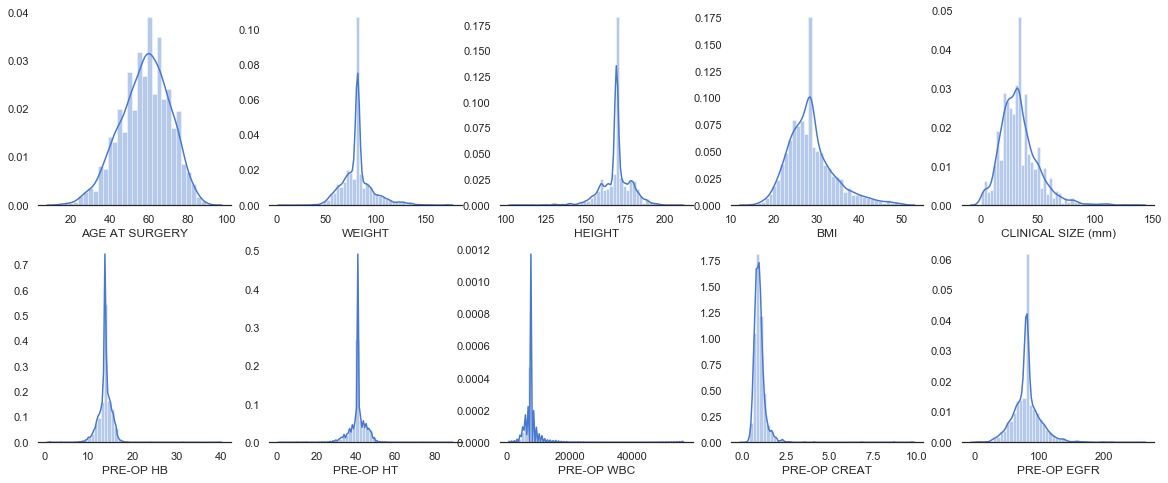

In [154]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)
rs = np.random.RandomState(10)
f, axes = plt.subplots(2, 5, figsize=(20, 8))
sns.despine(left=True)
# Plot a simple histogram with binsize determined automatically
sns.distplot(x_train['AGE AT SURGERY'], ax=axes[0, 0])
sns.distplot(x_train['WEIGHT'], ax=axes[0, 1])
sns.distplot(x_train['HEIGHT'],ax=axes[0,2])
sns.distplot(x_train['BMI'], ax=axes[0,3])
sns.distplot(x_train['CLINICAL SIZE (mm)'], ax=axes[0, 4])
sns.distplot(x_train['PRE-OP HB'], ax=axes[1, 0])
sns.distplot(x_train['PRE-OP HT'], ax=axes[1, 1])
sns.distplot(x_train['PRE-OP WBC'], ax=axes[1, 2])
sns.distplot(x_train['PRE-OP CREAT'],ax=axes[1,3])
sns.distplot(x_train['PRE-OP EGFR'], ax=axes[1,4])


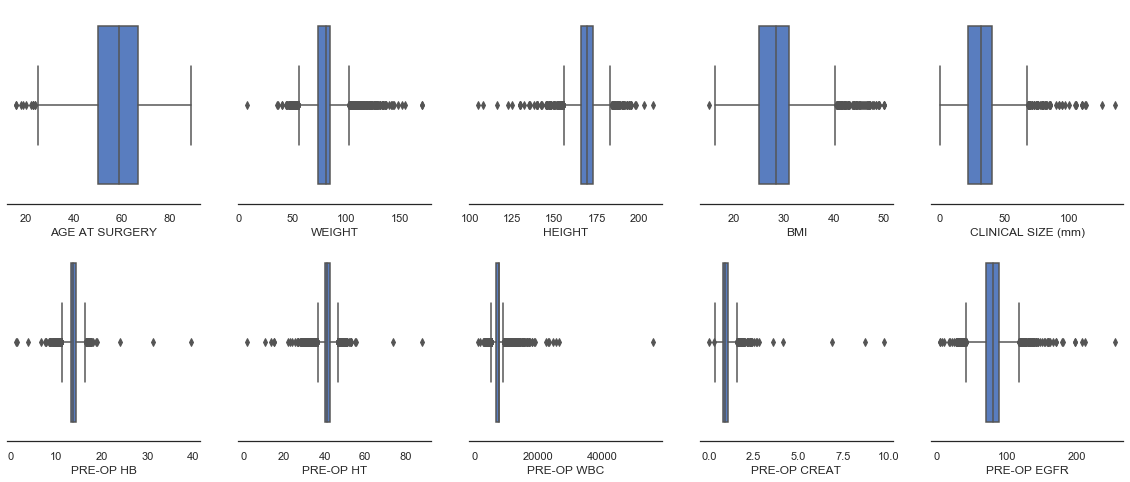

In [155]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)
rs = np.random.RandomState(10)
f, axes = plt.subplots(2, 5, figsize=(20, 8))
sns.despine(left=True)
# Plot a simple histogram with binsize determined automatically
sns.boxplot(x_train['AGE AT SURGERY'], ax=axes[0, 0])
sns.boxplot(x_train['WEIGHT'], ax=axes[0, 1])
sns.boxplot(x_train['HEIGHT'],ax=axes[0,2])
sns.boxplot(x_train['BMI'], ax=axes[0,3])
sns.boxplot(x_train['CLINICAL SIZE (mm)'], ax=axes[0, 4])
sns.boxplot(x_train['PRE-OP HB'], ax=axes[1, 0])
sns.boxplot(x_train['PRE-OP HT'], ax=axes[1, 1])
sns.boxplot(x_train['PRE-OP WBC'], ax=axes[1, 2])
sns.boxplot(x_train['PRE-OP CREAT'],ax=axes[1,3])
sns.boxplot(x_train['PRE-OP EGFR'], ax=axes[1,4])


In [156]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [157]:
numeric_features = x_train.select_dtypes('float').columns.tolist()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)], remainder='passthrough')

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
model = LogisticRegression()
parameter_dist = {'classifier__solver':['saga','liblinear','newton-cg','lbfgs'],
                  'classifier__class_weight': [None] ,
                  'classifier__penalty':['l2'],
                  'classifier__max_iter':[10000],
                  'classifier__class_weight':[None, 'balanced']
                 }



clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('pca',PCA()),
                      ('classifier', LogisticRegression())])
logit = GridSearchCV(clf,parameter_dist,n_jobs=-1,scoring= 'roc_auc', cv = 5)

In [181]:
#train and fit to original data
classifier_logit = logit.fit(x_train, y_train)
y_logit = classifier_logit.predict(x_test)

In [183]:
classifier = classifier_logit
results_logit = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_logit['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_logit['true_label'] = np.array(y_test)

In [184]:
# Logistic Regression Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_logit)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_logit)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_logit)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_logit['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_logit)))

{'classifier__class_weight': None, 'classifier__max_iter': 10000, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}

 Model Best CV score: 
0.5073526760709569

 Model Balanced Accuracy: 
0.5

 Confusion Matrix : 
[[944   0]
 [ 50   0]]


H:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



 Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       944
           1       0.00      0.00      0.00        50

    accuracy                           0.95       994
   macro avg       0.47      0.50      0.49       994
weighted avg       0.90      0.95      0.93       994


 AUC-ROC: 
0.586228813559322

 PR-ROC: 
0.07486085709907836


In [185]:
roc_auc_logit, pr_auc_logit = bootstrapped_AUC(results_logit)

In [186]:
dict = {'roc_auc_logit': roc_auc_logit,
        'pr_auc_logit': pr_auc_logit,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_logit,pr_auc_logit
count,10000.000000,10000.000000
mean,0.586447,0.078140
std,0.043015,0.019250
min,0.411153,0.029058
2.5%,0.501500,0.046675
50%,0.586406,0.075862
97.5%,0.670071,0.121945
max,0.758264,0.173839


# Compare Classifiers

H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


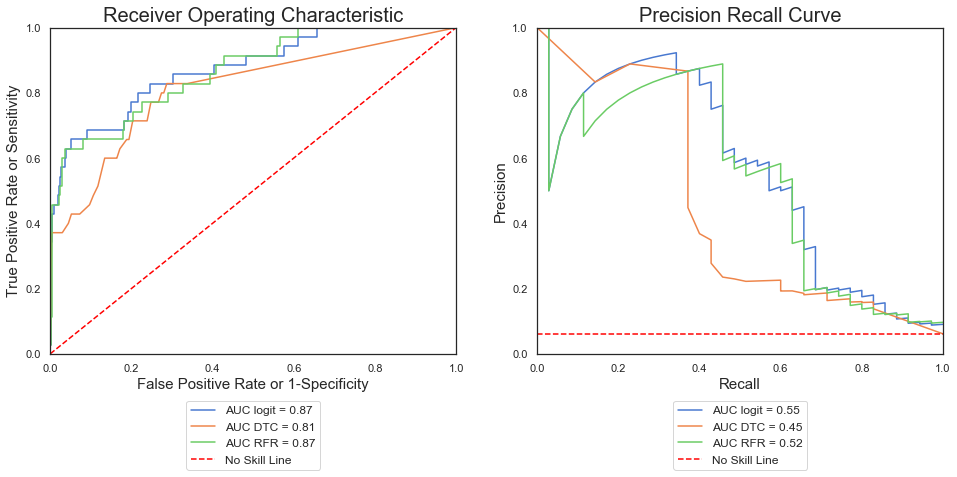

In [135]:
# Plotting AUROC Curve - Calculatae Metrics
from sklearn import metrics
def calc_aucroc_data(result):
    y_ACTUAL= result['true_label']
    scores_prob = result['pred_prob']
    fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    f1 = metrics.f1_score(y_ACTUAL, yhat)
    ap = metrics.average_precision_score(y_ACTUAL, yhat)
    postives_ratio = round(sum(result['true_label'])/(len(result['true_label'])),2)
    return recall, precision, f1, prc_auc, postives_ratio

fpr_logit, tpr_logit, thresholds_logit, roc_auc_logit = calc_aucroc_data(results_logit)
recall_logit, precision_logit, f1_logit, prc_auc_logit, postives_ratio_logit = calc_aucpr_data(results_logit)

fpr_DTC, tpr_DTC, thresholds_DTC, roc_auc_DTC = calc_aucroc_data(results_DTC)
recall_DTC, precision_DTC, f1_DTC, prc_auc_DTC, postives_ratio_DTC = calc_aucpr_data(results_DTC)

fpr_RFR, tpr_RFR, thresholds_RFR, roc_auc_RFR = calc_aucroc_data(results_RFR)
recall_RFR, precision_RFR, f1_RFR, prc_auc_RFR, postives_ratio_RFR = calc_aucpr_data(results_RFR)


import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))

# Plotting AUROC Curve - Plot Curve
ax1.set_title('Receiver Operating Characteristic',fontdict={"size":20})
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate or Sensitivity', fontdict={"size":15})
ax1.set_xlabel('False Positive Rate or 1-Specificity',fontdict={"size":15})
ax1.plot(fpr_logit, tpr_logit, label = 'AUC logit = %0.2f' % roc_auc_logit)
ax1.plot(fpr_DTC, tpr_DTC, label = 'AUC DTC = %0.2f' % roc_auc_DTC)
ax1.plot(fpr_RFR, tpr_RFR, label = 'AUC RFR = %0.2f' % roc_auc_RFR)
ax1.plot([0, 1], [0, 1],linestyle='--',color='red', label = 'No Skill Line')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), fontsize = 12)  

# Plotting Precision-Recall Curve - PLot Curve
ax2.set_title('Precision Recall Curve',fontdict={"size":20})
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('Precision',fontdict={"size":15})
ax2.set_xlabel('Recall',fontdict={"size":15})
ax2.plot(recall_logit, precision_logit, label = 'AUC logit = %.2f' % (prc_auc_logit))
ax2.plot(recall_DTC, precision_DTC, label = 'AUC DTC = %.2f' % (prc_auc_DTC))
ax2.plot(recall_RFR, precision_RFR, label = 'AUC RFR = %.2f' % (prc_auc_RFR))
positive_class_ratio = postives_ratio_logit
ax2.plot([0, 1], [positive_class_ratio, positive_class_ratio],linestyle='--',color='red', label = 'No Skill Line')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fontsize = 12)

fig.show()



In [252]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
rfe = RFE(logreg, 30)
rfe = rfe.fit(x_test, y_test)
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
 False False False  True  True False False False  True False False  True
 False False False  True False False  True False False False  True  True
 False  True False False False False  True False  True False False False
  True False False False  True False False False  True  True  True False
  True False False  True False False  True False False False False False
 False False False False  True False  True False  True False  True False
  True False False False  True False  True False  True False  True False
 False False  True  True False False]
[ 9 55 31 48 63 33 61  6 40 41 13 71 30 32 64  1  1 53 70 37  1  8 29  1
 60 56 12  1 23 54  1  4 28  5  1  1 46  1 42 72 22 67  1  3  1  2 10 50
  1 34 16 45  1 17 73 51  1  1  1 52  1 59 20  1 21 65  1 62 39 35 66 57
 69 58 44 43  1 36  1 15  1 19  1  7  1 25 38 24  1 27  1 14  1 26  1 47
 68 49  1  1 11 18]


In [253]:
x_test.columns[rfe.support_]

Index(['MARITAL STATUS_0', 'MARITAL STATUS_1', 'RACE_0', 'RACE_3',
       'SYMPTOMS_2', 'SOLITARY KIDNEY_1', 'BILATERALITY OF TUMOR_2',
       'SIDE OF TUMOR_0', 'SIDE OF TUMOR_2', 'SIDE OF SURGERY_3', 'FACE_1',
       'TUMOR lOCATION_2', 'POLAR LOCATION_2', 'RENAL SINUS_3',
       'RENAL SINUS_4', 'EXOPHYTIC RATE_0', 'EXOPHYTIC RATE_2',
       'CLINICAL SIZE GROUP_1', 'CT_0', 'CN_3', 'CM_1', 'CM_3',
       'RADIUS (maximal diameter in cm)_1',
       'RADIUS (maximal diameter in cm)_3',
       'EXOPHYTIC/ENDOPHYTIC PROPERTIES_3', 'ANTERIOR OR POSTERIOR_1',
       'ANTERIOR OR POSTERIOR_3', 'ASA SCORE_1', 'PARTIAL NEPHRO INDICATION_0',
       'PARTIAL NEPHRO INDICATION_1'],
      dtype='object')

In [254]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,x_train[x_test.columns[rfe.support_]])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.157566
         Iterations 9
                                 Results: Logit
Model:                   Logit                    Pseudo R-squared:    0.347     
Dependent Variable:      INTRA-OP COMPLICATION    AIC:                 778.8176  
Date:                    2019-08-05 16:07         BIC:                 950.7887  
No. Observations:        2281                     Log-Likelihood:      -359.41   
Df Model:                29                       LL-Null:             -550.56   
Df Residuals:            2251                     LLR p-value:         2.8266e-63
Converged:               1.0000                   Scale:               1.0000    
No. Iterations:          9.0000                                                  
---------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------